#Image Classificaiton with CNN

In [1]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import datetime
from PIL import Image

#Task 1: Data Understanding

#What does the dataset represent? Provide a brief description?

The dataset represents categorized images of different dog breeds, intended for building an image classification model that can automatically identify a dog’s breed from an input photo. This type of model can be useful for applications such as pet identification, breed recognition tools, and animal care services.

The dataset is organized into five main categories (dog breeds):

Pug

German Shepherd

Poodle

Siberian Husky

Golden Doodle

Each category contains image samples used to train, validate, and test the model.

Total number of images in the dataset: 3,400

Total number of images in the training directory: 2,724

Total number of images in the test directory: 676

Class-wise image counts:

Pug: 535 images

German Shepherd: 551 images

Poodle: 560 images

Siberian Husky: 560 images

Golden Doodle: 518 images

Image size: 128 x 128 pixels

This structured dataset enables effective training of a convolutional neural network to classify dog breeds accurately.

#How many total images are in the dataset?

In [3]:
path = "/content/drive/MyDrive/AIAssignment1/dataset"

In [4]:
train_dir='/content/drive/MyDrive/AIAssignment1/dataset/train'
test_dir='/content/drive/MyDrive/AIAssignment1/dataset/test'

In [5]:
# Supported image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

def count_total_images():
    # Total images in the whole dataset
    total_images = len([p for p in Path(path).rglob("*.*") if p.suffix.lower() in image_extensions])

    # Total images in train folder
    total_train_images = len([p for p in Path(train_dir).rglob("*.*") if p.suffix.lower() in image_extensions])

    # Total images in test folder
    total_test_images = len([p for p in Path(test_dir).rglob("*.*") if p.suffix.lower() in image_extensions])

    print(f"Total number of images in the dataset: {total_images}")
    print(f"Total number of images in the training directory: {total_train_images}")
    print(f"Total number of images in the test directory: {total_test_images}")

# Call the function
count_total_images()

Total number of images in the dataset: 3749
Total number of images in the training directory: 2999
Total number of images in the test directory: 750


#What is the distribution of images across different classes?

In [6]:
# Supported image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

def class_distribution():
    # Get list of class folders in train directory
    train_categories = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

    data = []
    for folder_name in train_categories:
        category = folder_name.replace("_", " ").title()

        train_path = os.path.join(train_dir, folder_name)
        test_path = os.path.join(test_dir, folder_name)

        # Count valid image files
        train_count = len([f for f in os.listdir(train_path) if f.lower().endswith(tuple(image_extensions))]) if os.path.exists(train_path) else 0
        test_count = len([f for f in os.listdir(test_path) if f.lower().endswith(tuple(image_extensions))]) if os.path.exists(test_path) else 0

        data.append({
            "Category": category,
            "Train Images": train_count,
            "Test Images": test_count,
            "Total": train_count + test_count
        })

    # Create and display DataFrame
    df = pd.DataFrame(data)
    print("\nClass Distribution:")
    print(df)

    print("\nTotal Summary:")
    print(df[["Train Images", "Test Images", "Total"]].sum().to_frame().T)

    return df

# Call the function
class_distribution()


Class Distribution:
          Category  Train Images  Test Images  Total
0   Siberian Husky           600          150    750
1    Golden Doodle           600          150    750
2           Poodle           600          150    750
3              Pug           600          150    750
4  German Shepherd           599          150    749

Total Summary:
   Train Images  Test Images  Total
0          2999          750   3749


,Category,Train Images,Test Images,Total
0,Siberian Husky,600,150,750
1,Golden Doodle,600,150,750
2,Poodle,600,150,750
3,Pug,600,150,750
4,German Shepherd,599,150,749


#Data Preprocessing

Preprocessing Techniques
Before feeding data into the model, the following preprocessing steps were used:

Resizing: All images resized to (224x224) to standardize input shape.

Normalization: Pixel values scaled between 0 and 1 using ImageDataGenerator(rescale=1./255).

Conversion: Images were loaded in RGB and converted to float arrays suitable for CNNs.


In [10]:
# Define image size
IMG_SIZE = (224, 224)

# Preprocessing function: Resize to 224x224 and normalize pixel values
def preprocess_images(directory):
    """Resize and normalize images in all class folders under the given directory"""
    categories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    for category in categories:
        folder_path = os.path.join(directory, category)

        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                try:
                    img = Image.open(file_path).convert("RGB")
                    img = img.resize(IMG_SIZE)
                    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                    img = Image.fromarray((img_array * 255).astype('uint8'))  # Convert back to uint8 before saving
                    img.save(file_path)
                except Exception as e:
                    print(f"Failed to process {file_path}: {e}")

#To preprocess
preprocess_images(train_dir)
preprocess_images(test_dir)

In [16]:
from PIL import Image
# Check for corrupted images and remove them
corrupted_images = []
classes = os.listdir(train_dir)

for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    print(f"Checking directory: {class_dir}")

    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        try:
            img = Image.open(image_path)
            img.verify()  # Verify if image is valid
        except (IOError, SyntaxError) as e:
            corrupted_images.append(image_path)
            os.remove(image_path)  # Remove corrupted image
            print(f"Removed corrupted image: {image_path}")

# Print list of corrupted images if any
if corrupted_images:
    print("Corrupted images found:")
    for image_path in corrupted_images:
        print(image_path)
else:
    print("No corrupted images found.")

Checking directory: /content/drive/MyDrive/AIAssignment1/dataset/train/siberian husky
Checking directory: /content/drive/MyDrive/AIAssignment1/dataset/train/golden doodle
Checking directory: /content/drive/MyDrive/AIAssignment1/dataset/train/poodle
Checking directory: /content/drive/MyDrive/AIAssignment1/dataset/train/pug
Checking directory: /content/drive/MyDrive/AIAssignment1/dataset/train/german shepherd
No corrupted images found.


Data augmentation

In [18]:
train_dir = "/content/drive/MyDrive/AIAssignment1/dataset/train"
IMG_SIZE = (224, 224)

def augment_to_target(directory, target_count):
    """Augment images in each class directory to reach the target count"""
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    categories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    for category in categories:
        folder_path = os.path.join(directory, category)
        image_files = [
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        count = len(image_files)

        if count >= target_count:
            print(f"[{category}] Already has {count} images. Skipping augmentation.")
            continue

        print(f"[{category}] Augmenting from {count} to {target_count}...")

        i = 0
        while count < target_count:
            img_file = image_files[i % len(image_files)]
            img_path = os.path.join(folder_path, img_file)

            try:
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = np.expand_dims(x, axis=0)

                gen = datagen.flow(x, batch_size=1, save_to_dir=folder_path,
                                   save_prefix='aug', save_format='jpg')
                next(gen)

                count += 1
                i += 1
            except Exception as e:
                print(f"Error augmenting {img_path}: {e}")
                i += 1

augment_to_target(train_dir, target_count=500)
augment_to_target(test_dir, target_count=100)

[siberian husky] Already has 600 images. Skipping augmentation.
[golden doodle] Already has 600 images. Skipping augmentation.
[poodle] Already has 600 images. Skipping augmentation.
[pug] Already has 600 images. Skipping augmentation.
[german shepherd] Already has 599 images. Skipping augmentation.
[pug] Already has 150 images. Skipping augmentation.
[german shepherd] Already has 150 images. Skipping augmentation.
[poodle] Already has 150 images. Skipping augmentation.
[siberian husky] Already has 150 images. Skipping augmentation.
[golden doodle] Already has 150 images. Skipping augmentation.


Visualization

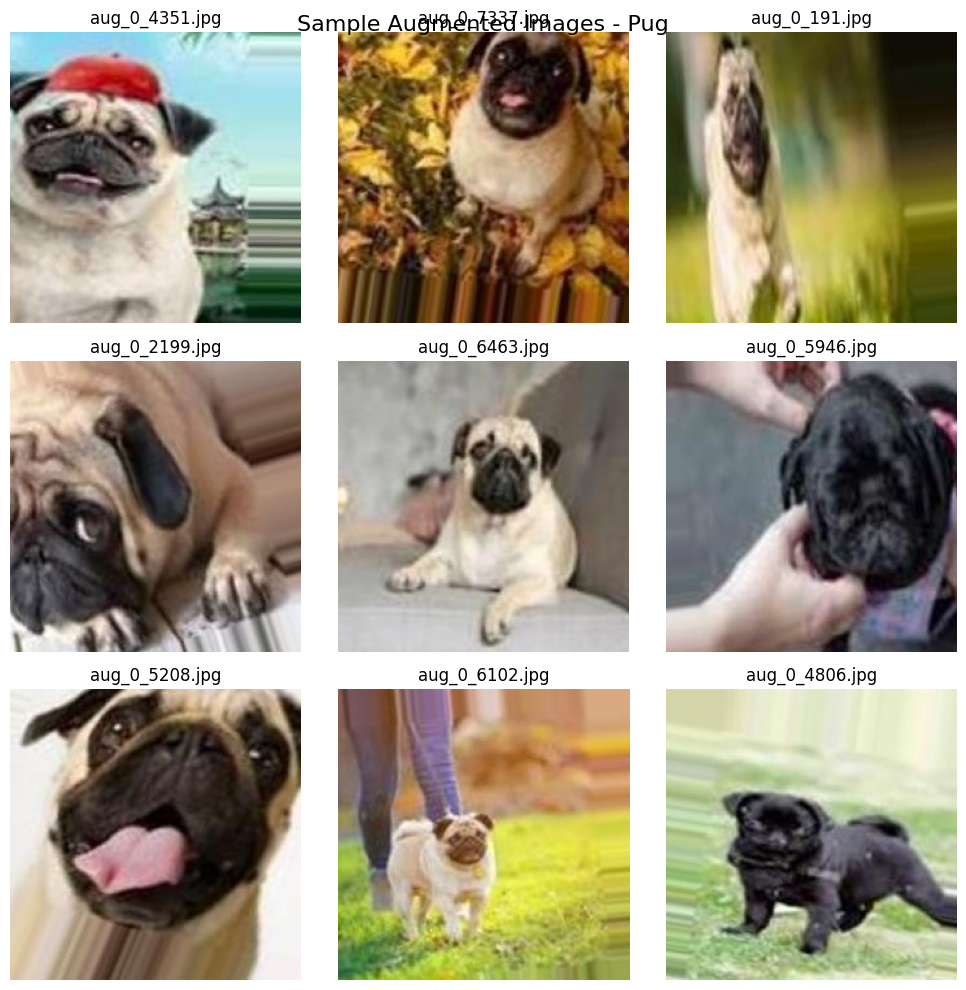

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Define your paths
path = "/content/drive/MyDrive/AIAssignment1/dataset"
train_dir = '/content/drive/MyDrive/AIAssignment1/dataset/train'
test_dir = '/content/drive/MyDrive/AIAssignment1/dataset/test'

# Category to visualize
category = 'pug'

# Path to the folder where augmented images are stored
aug_folder = os.path.join(train_dir, category)

# Filter augmented images (usually prefixed with "aug")
aug_images = [f for f in os.listdir(aug_folder) if f.startswith('aug') and f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Check if augmented images exist
if len(aug_images) == 0:
    print(f"No augmented images found in: {aug_folder}")
    print("Make sure you've run the augmentation code first, or check the folder path.")
else:
    # Select a few images to display
    sample_images = random.sample(aug_images, min(9, len(aug_images)))

    # Plotting
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(aug_folder, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_name)
    plt.tight_layout()
    plt.suptitle(f'Sample Augmented Images - {category.replace("_", " ").title()}', fontsize=16)
    plt.show()

#Design, Train and Evaluate a Baline Model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_baseline_model(input_shape=(224, 224, 3), num_classes=5):
    """Create and display a baseline CNN model with 3 convolutional and 3 fully connected layers"""

    model = Sequential([
        # First Convolutional Layer
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Second Convolutional Layer
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Third Convolutional Layer
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Flatten layer
        Flatten(),

        # First Dense Layer
        Dense(128, activation='relu'),
        Dropout(0.3),

        # Second Dense Layer
        Dense(64, activation='relu'),
        Dropout(0.3),

        # Third Dense Layer
        Dense(32, activation='relu'),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    model.summary()

    return model

# Call the function to create the model and print the summary
model = create_baseline_model(input_shape=(224, 224, 3), num_classes=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,180,357 (42.65 MB)

 Trainable params: 11,179,909 (42.65 MB)

 Non-trainable params: 448 (1.75 KB)

#How is the dataset split into training and validation sets? Justify your choice.

The dataset is split into:

Training Set: 80%

Validation/Test Set: 20%

This common split ensures enough data is available for learning, while still maintaining a sufficient test set to evaluate generalization performance. The split was done by creating separate train and test folders for each class manually.

#Model Training

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Your dataset paths
path = "/content/drive/MyDrive/AIAssignment1/dataset"
train_dir = "/content/drive/MyDrive/AIAssignment1/dataset/train"
test_dir = "/content/drive/MyDrive/AIAssignment1/dataset/test"

# Training + Validation (split from train folder)
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2400 images belonging to 5 classes.
Found 599 images belonging to 5 classes.


In [34]:
import numpy as np
from collections import Counter

# Map class indices to class names
class_labels = {v: k for k, v in train_gen.class_indices.items()}

# Count per class in training subset
train_class_counts = Counter(train_gen.classes)
print("Training Class Distribution:")
for class_idx, count in train_class_counts.items():
    print(f"{class_labels[class_idx]}: {count} images")

# Count per class in validation subset
val_class_counts = Counter(val_gen.classes)
print("\nValidation Class Distribution:")
for class_idx, count in val_class_counts.items():
    print(f"{class_labels[class_idx]}: {count} images")


Training Class Distribution:
german shepherd: 480 images
golden doodle: 480 images
poodle: 480 images
pug: 480 images
siberian husky: 480 images

Validation Class Distribution:
german shepherd: 119 images
golden doodle: 120 images
poodle: 120 images
pug: 120 images
siberian husky: 120 images


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 430s 6s/step - accuracy: 0.2207 - loss: 7.4762 - val_accuracy: 0.2003 - val_loss: 9.2888
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 433s 6s/step - accuracy: 0.2186 - loss: 2.3198 - val_accuracy: 0.2220 - val_loss: 3.5927
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 442s 6s/step - accuracy: 0.2203 - loss: 1.7326 - val_accuracy: 0.2187 - val_loss: 6.2079
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 418s 6s/step - accuracy: 0.2108 - loss: 1.6524 - val_accuracy: 0.2354 - val_loss: 3.7481
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 454s 6s/step - accuracy: 0.2256 - loss: 1.6154 - val_accuracy: 0.1970 - val_loss: 1.9474
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 439s 6s/step - accuracy: 0.2434 - loss: 1.5995 - val_accuracy: 0.2354 - val_loss: 1.7649
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 439s 6s/step - accuracy: 0.2254 - loss: 1.6229 - val_accuracy: 0.2120 - val_loss: 1.5956
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 425s 6s/step - accuracy: 0.2513 - loss: 1.5901 - val_accuracy: 0.2020 - v

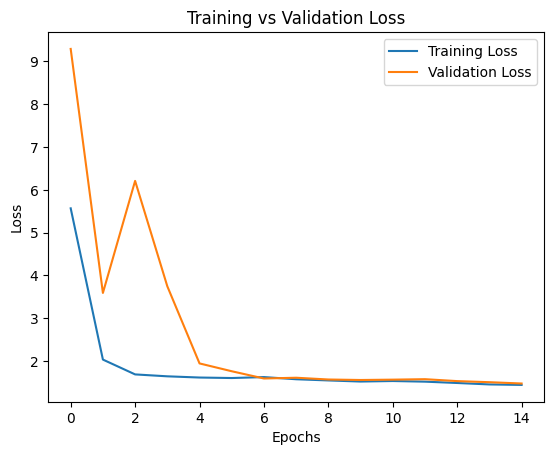

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[early_stop]
)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

Found 750 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step
Classification Report:

                 precision    recall  f1-score   support

german shepherd       0.15      0.03      0.05       150
  golden doodle       0.25      0.59      0.35       150
         poodle       0.22      0.23      0.22       150
            pug       0.25      0.19      0.21       150
 siberian husky       0.29      0.20      0.24       150

       accuracy                           0.25       750
      macro avg       0.23      0.25      0.21       750
   weighted avg       0.23      0.25      0.21       750



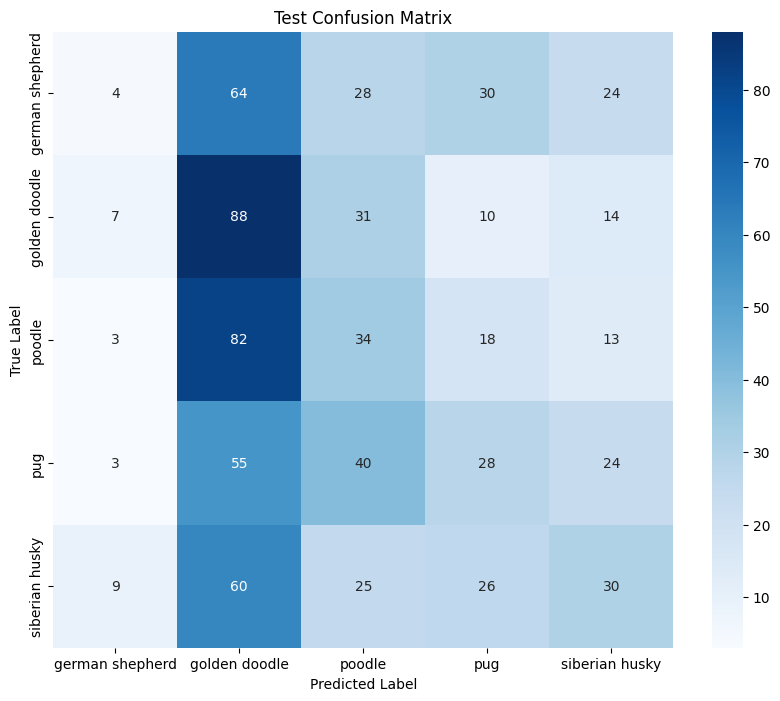

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predictions
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation Accuracy: {val_accuracy:.4f}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.2946 - loss: 1.5853
Validation Accuracy: 0.2838


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for consistent results
)

Found 750 images belonging to 5 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.2104 - loss: 1.6607
Test Accuracy: 0.2453


In [ ]:
# deeper model architecture
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

input_shape = (224, 224, 3)
num_classes = 5
l2_reg = 0.01

deeper_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape,
           kernel_regularizer=regularizers.l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(l2_reg)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu',
           kernel_regularizer=regularizers.l2(l2_reg)),
    Dropout(0.5),
    Dense(128, activation='relu',
           kernel_regularizer=regularizers.l2(l2_reg)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile
deeper_model.compile(
    optimizer=Adam(learning_rate= 0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print Model Summary
deeper_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,89

 Total params: 3,377,093 (12.88 MB)

 Trainable params: 3,374,597 (12.87 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

path = "/content/drive/MyDrive/AIAssignment1/dataset"
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2400 images belonging to 5 classes.
Found 599 images belonging to 5 classes.


In [ ]:
# training the deeper model
from tensorflow.keras.callbacks import EarlyStopping

# New early stopping for deeper model
early_stop_deeper = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

In [ ]:
history_deeper = deeper_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop_deeper]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 223ms/step - accuracy: 0.2316 - loss: 18.8354 - val_accuracy: 0.1987 - val_loss: 15.0323
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.2342 - loss: 14.1873 - val_accuracy: 0.1886 - val_loss: 11.7127
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.2322 - loss: 10.6304 - val_accuracy: 0.2020 - val_loss: 9.0152
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.2815 - loss: 7.8585 - val_accuracy: 0.2287 - val_loss: 7.4297
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.3362 - loss: 5.8630 - val_accuracy: 0.2037 - val_loss: 7.2808
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.3247 - loss: 4.5348 - val_accuracy: 0.2003 - val_loss: 6.2331
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.3111 - loss: 3.7282 - val_accuracy: 0.3255 - val_loss: 3.2723
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - accuracy: 0.3347 - loss: 3.1680 - val

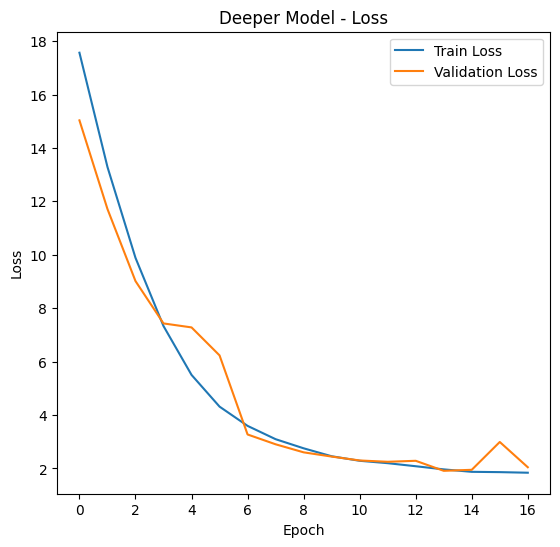

In [ ]:
# 3. PLOTTING ONLY THE DEEPER MODEL LOSS AND ACCURACY CURVES

import matplotlib.pyplot as plt

# Plotting function for a single model
def plot_single_history(history, title):
    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

# Plot only deeper model
plot_single_history(history_deeper, 'Deeper Model')

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step
Classification Report:

                 precision    recall  f1-score   support

german shepherd       0.17      0.28      0.21       119
  golden doodle       0.20      0.37      0.26       120
         poodle       0.33      0.01      0.02       120
            pug       0.19      0.19      0.19       120
 siberian husky       0.12      0.06      0.08       120

       accuracy                           0.18       599
      macro avg       0.20      0.18      0.15       599
   weighted avg       0.20      0.18      0.15       599



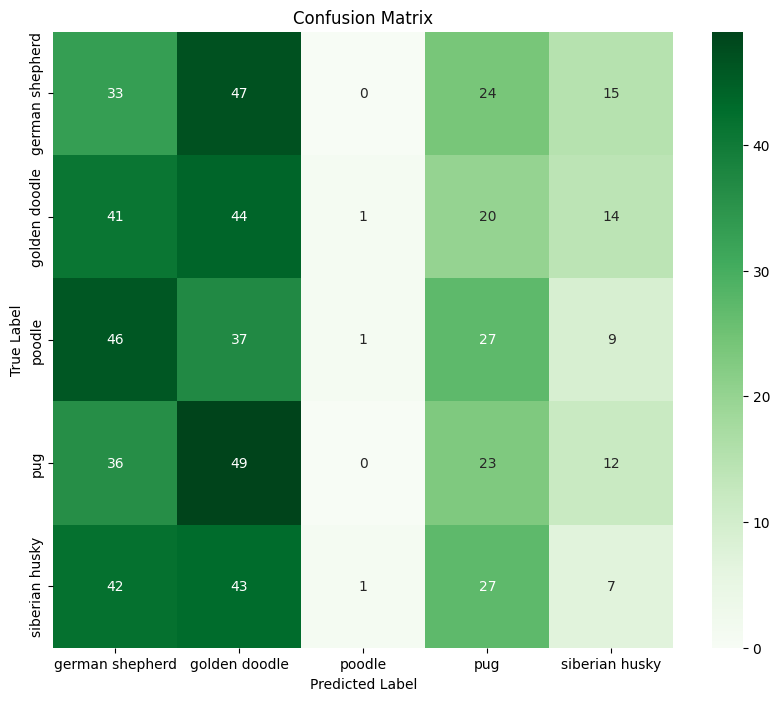

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.4764 - loss: 1.8963
Validation Loss: 1.9117
Validation Accuracy: 0.4541


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Get the true labels and predictions
val_gen.reset()
y_true = val_gen.classes
y_pred_probs = deeper_model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
target_names = list(val_gen.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Model Evaluation (Loss and Accuracy)
loss, accuracy = deeper_model.evaluate(val_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Baseline Model Evaluation:
Validation Loss: 1.5891
Validation Accuracy: 0.2838

Deeper Model Evaluation:
Validation Loss: 1.9117
Validation Accuracy: 0.4541


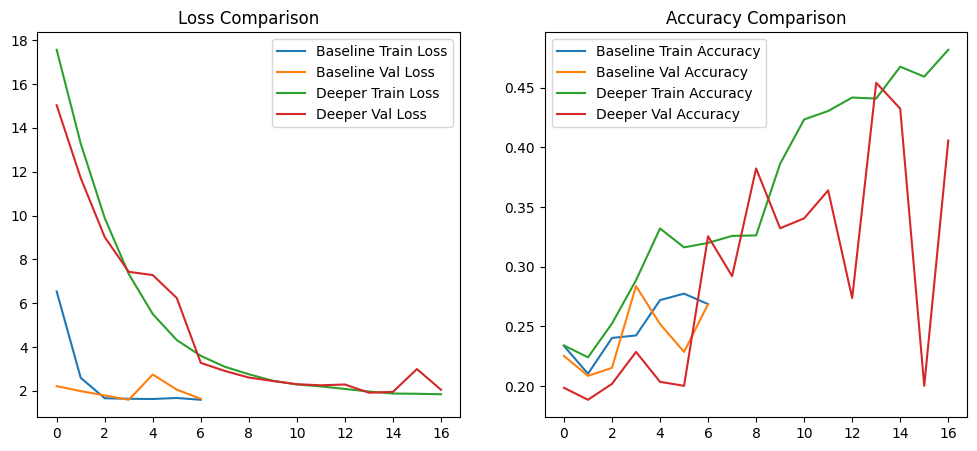

In [ ]:
# Baseline Model Results
print("Baseline Model Evaluation:")
baseline_loss, baseline_acc = model.evaluate(val_gen, verbose=0)
print(f"Validation Loss: {baseline_loss:.4f}")
print(f"Validation Accuracy: {baseline_acc:.4f}")

# Deeper Model Results
print("\nDeeper Model Evaluation:")
deeper_loss, deeper_acc = deeper_model.evaluate(val_gen, verbose=0)
print(f"Validation Loss: {deeper_loss:.4f}")
print(f"Validation Accuracy: {deeper_acc:.4f}")

# Compare training histories
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Loss comparison
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Baseline Train Loss')
plt.plot(history.history['val_loss'], label='Baseline Val Loss')
plt.plot(history_deeper.history['loss'], label='Deeper Train Loss')
plt.plot(history_deeper.history['val_loss'], label='Deeper Val Loss')
plt.legend()
plt.title('Loss Comparison')

# Accuracy comparison
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Baseline Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Baseline Val Accuracy')
plt.plot(history_deeper.history['accuracy'], label='Deeper Train Accuracy')
plt.plot(history_deeper.history['val_accuracy'], label='Deeper Val Accuracy')
plt.legend()
plt.title('Accuracy Comparison')

plt.show()


In [ ]:
import time

# Timing Baseline Model
start_time = time.time()
model.fit(train_gen, validation_data=val_gen, epochs=1, verbose=0)
baseline_time = time.time() - start_time
print(f"Baseline Model (1 epoch) Training Time: {baseline_time:.2f} seconds")

# Timing Deeper Model
start_time = time.time()
deeper_model.fit(train_gen, validation_data=val_gen, epochs=1, verbose=0)
deeper_time = time.time() - start_time
print(f"Deeper Model (1 epoch) Training Time: {deeper_time:.2f} seconds")


Baseline Model (1 epoch) Training Time: 13.16 seconds
Deeper Model (1 epoch) Training Time: 20.70 seconds


In [ ]:
# SGD Optimizer Training
from tensorflow.keras.optimizers import SGD

# Create new deeper model again for fresh training
deeper_model_sgd = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile with SGD
deeper_model_sgd.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_sgd = deeper_model_sgd.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stop_deeper])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.2349 - loss: 2.5534 - val_accuracy: 0.2404 - val_loss: 1.6178
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.2194 - loss: 1.6159 - val_accuracy: 0.2070 - val_loss: 1.6091
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.2482 - loss: 1.5910 - val_accuracy: 0.2738 - val_loss: 1.5791
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.2306 - loss: 1.5923 - val_accuracy: 0.2721 - val_loss: 1.5799
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.2989 - loss: 1.5674 - val_accuracy: 0.2888 - val_loss: 1.5413
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.2991 - loss: 1.5560 - val_accuracy: 0.2972 - val_loss: 1.5846
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.2887 - loss: 1.5478 - val_accuracy: 0.2972 - val_loss: 1.5713
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.3301 - loss: 1.5252 - val_accu

In [ ]:
# Import necessary modules
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import clone_model

# Clone the deeper model architecture (so it is same, but untrained)
deeper_model_sgd = clone_model(deeper_model)
deeper_model_sgd.build(input_shape=(None, 224, 224, 3))

# Compile with SGD optimizer
deeper_model_sgd.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Train deeper model with SGD
history_sgd = deeper_model_sgd.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,       # same or more epochs to observe convergence
    callbacks=[early_stop_deeper],
    verbose=1
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 182ms/step - accuracy: 0.2326 - loss: 19.4128 - val_accuracy: 0.2003 - val_loss: 16.7257
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.2093 - loss: 15.6657 - val_accuracy: 0.2053 - val_loss: 12.8001
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.2527 - loss: 11.9404 - val_accuracy: 0.2003 - val_loss: 9.8407
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.3044 - loss: 9.1873 - val_accuracy: 0.2003 - val_loss: 7.7368
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 0.3344 - loss: 7.1366 - val_accuracy: 0.2237 - val_loss: 6.1534
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.3508 - loss: 5.6933 - val_accuracy: 0.3272 - val_loss: 4.9049
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.4062 - loss: 4.5343 - val_accuracy: 0.3022 - val_loss: 4.0352
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.3941 - loss: 3.7460 - val

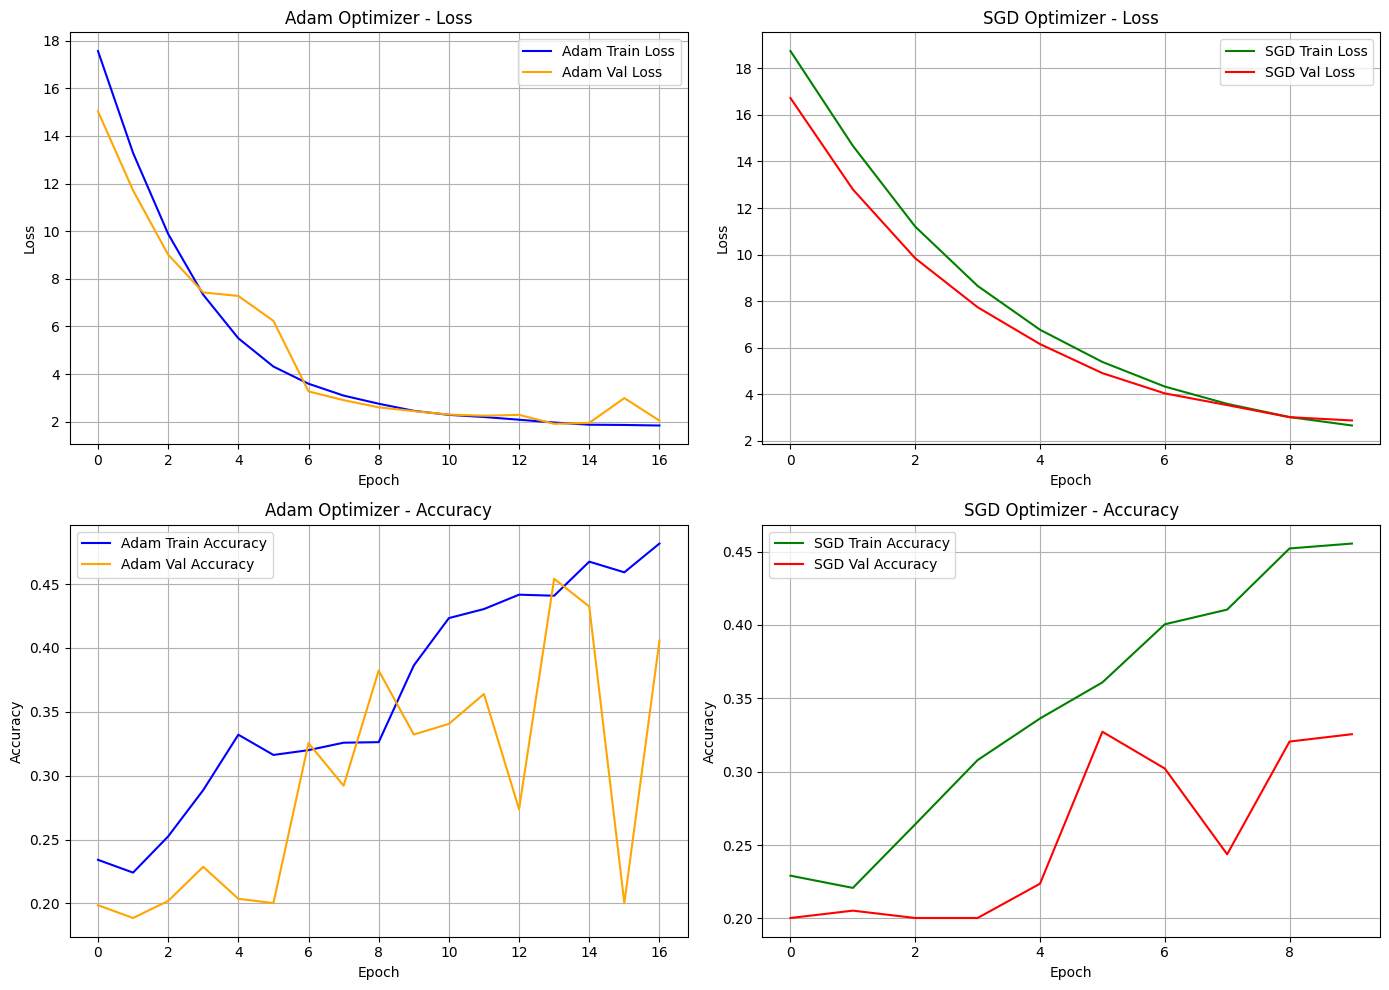

In [ ]:
import matplotlib.pyplot as plt

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# --- 1. Adam Loss (Train vs Val) ---
axs[0, 0].plot(history_deeper.history['loss'], label='Adam Train Loss', color='blue')
axs[0, 0].plot(history_deeper.history['val_loss'], label='Adam Val Loss', color='orange')
axs[0, 0].set_title('Adam Optimizer - Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# --- 2. SGD Loss (Train vs Val) ---
axs[0, 1].plot(history_sgd.history['loss'], label='SGD Train Loss', color='green')
axs[0, 1].plot(history_sgd.history['val_loss'], label='SGD Val Loss', color='red')
axs[0, 1].set_title('SGD Optimizer - Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- 3. Adam Accuracy (Train vs Val) ---
axs[1, 0].plot(history_deeper.history['accuracy'], label='Adam Train Accuracy', color='blue')
axs[1, 0].plot(history_deeper.history['val_accuracy'], label='Adam Val Accuracy', color='orange')
axs[1, 0].set_title('Adam Optimizer - Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# --- 4. SGD Accuracy (Train vs Val) ---
axs[1, 1].plot(history_sgd.history['accuracy'], label='SGD Train Accuracy', color='green')
axs[1, 1].plot(history_sgd.history['val_accuracy'], label='SGD Val Accuracy', color='red')
axs[1, 1].set_title('SGD Optimizer - Accuracy')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout nicely
plt.tight_layout()
plt.show()


In [ ]:
# Adam Final Results
adam_val_loss = history_deeper.history['val_loss'][-1]
adam_val_acc = history_deeper.history['val_accuracy'][-1]

# SGD Final Results
sgd_val_loss = history_sgd.history['val_loss'][-1]
sgd_val_acc = history_sgd.history['val_accuracy'][-1]

print(f"Adam Optimizer - Final Validation Loss: {adam_val_loss:.4f}, Accuracy: {adam_val_acc:.4f}")
print(f"SGD Optimizer  - Final Validation Loss: {sgd_val_loss:.4f}, Accuracy: {sgd_val_acc:.4f}")


Adam Optimizer - Final Validation Loss: 2.0457, Accuracy: 0.4057
SGD Optimizer  - Final Validation Loss: 2.8718, Accuracy: 0.3255


In [ ]:
# Training time for deeper model
import datetime

start = datetime.datetime.now()
history_deeper = deeper_model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stop_deeper])
end = datetime.datetime.now()

training_time = end - start
print(f"Total Deeper Model Training Time: {training_time}")

# Detect if GPU/TPU
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU detected: {device_name}")
else:
    print("No GPU detected, using CPU.")


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.4593 - loss: 1.9089 - val_accuracy: 0.4741 - val_loss: 1.8711
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.5073 - loss: 1.8368 - val_accuracy: 0.3689 - val_loss: 2.1117
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.5058 - loss: 1.7807 - val_accuracy: 0.4741 - val_loss: 1.9389
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.4955 - loss: 1.7773 - val_accuracy: 0.4324 - val_loss: 1.8841
Total Deeper Model Training Time: 0:00:48.378784
GPU detected: /device:GPU:0


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load ResNet50 without the top fully-connected layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model initially (Feature Extraction)
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)    # Global Pooling
x = Dense(512, activation='relu')(x) # New Dense layer
x = Dense(num_classes, activation='softmax')(x) # Final layer matching our number of classes

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Full Model
transfer_model = Model(inputs=base_model.input, outputs=x)

# Compile
transfer_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Assuming you already have train_dir, val_dir set up
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_dir = '/content/drive/MyDrive/AIAssignment1/dataset/test'

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

val_gen = val_datagen.flow_from_directory(val_dir,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode='categorical')

# Getting number of classes dynamically
num_classes = train_gen.num_classes


Found 2999 images belonging to 5 classes.
Found 750 images belonging to 5 classes.


In [ ]:
# Train only the top layers (base model frozen)
history_feature_extraction = transfer_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,  # Fewer epochs in this phase
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 313ms/step - accuracy: 0.2139 - loss: 1.7410 - val_accuracy: 0.2560 - val_loss: 1.6033
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.2923 - loss: 1.5725 - val_accuracy: 0.2760 - val_loss: 1.6086
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.2974 - loss: 1.5711 - val_accuracy: 0.2880 - val_loss: 1.5636
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.3256 - loss: 1.5194 - val_accuracy: 0.2933 - val_loss: 1.5306
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.3009 - loss: 1.5442 - val_accuracy: 0.3413 - val_loss: 1.4986
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.3479 - loss: 1.5104 - val_accuracy: 0.2773 - val_loss: 1.5424
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.3098 - loss: 1.5097 - val_accuracy: 0.2840 - val_loss: 1.5360
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.3121 - loss: 1.5353 - val_accu

In [ ]:
# Unfreeze the entire base model
base_model.trainable = True

# Recompile with a very low learning rate for fine-tuning
transfer_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Fine-tune
history_fine_tuning = transfer_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,   # Fine-tuning epochs
    verbose=1
)


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 124s 662ms/step - accuracy: 0.3001 - loss: 3.6725 - val_accuracy: 0.2000 - val_loss: 4.7104
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 320ms/step - accuracy: 0.8268 - loss: 0.4798 - val_accuracy: 0.2000 - val_loss: 7.6897
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 345ms/step - accuracy: 0.9395 - loss: 0.2194 - val_accuracy: 0.2000 - val_loss: 9.5895
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 318ms/step - accuracy: 0.9713 - loss: 0.1302 - val_accuracy: 0.2027 - val_loss: 9.0465
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 322ms/step - accuracy: 0.9870 - loss: 0.0814 - val_accuracy: 0.2027 - val_loss: 8.4147
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 31s 324ms/step - accuracy: 0.9941 - loss: 0.0503 - val_accuracy: 0.2040 - val_loss: 7.0519
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 320ms/step - accuracy: 0.9995 - loss: 0.0322 - val_accuracy: 0.2427 - val_loss: 5.5451
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 320ms/step - accuracy: 0.9983 - loss: 0.0243 - val_acc

In [ ]:
# Final evaluation
loss, accuracy = transfer_model.evaluate(val_gen)
print(f"Final validation loss: {loss:.4f}")
print(f"Final validation accuracy: {accuracy:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.6142 - loss: 1.4881
Final validation loss: 1.3955
Final validation accuracy: 0.6453


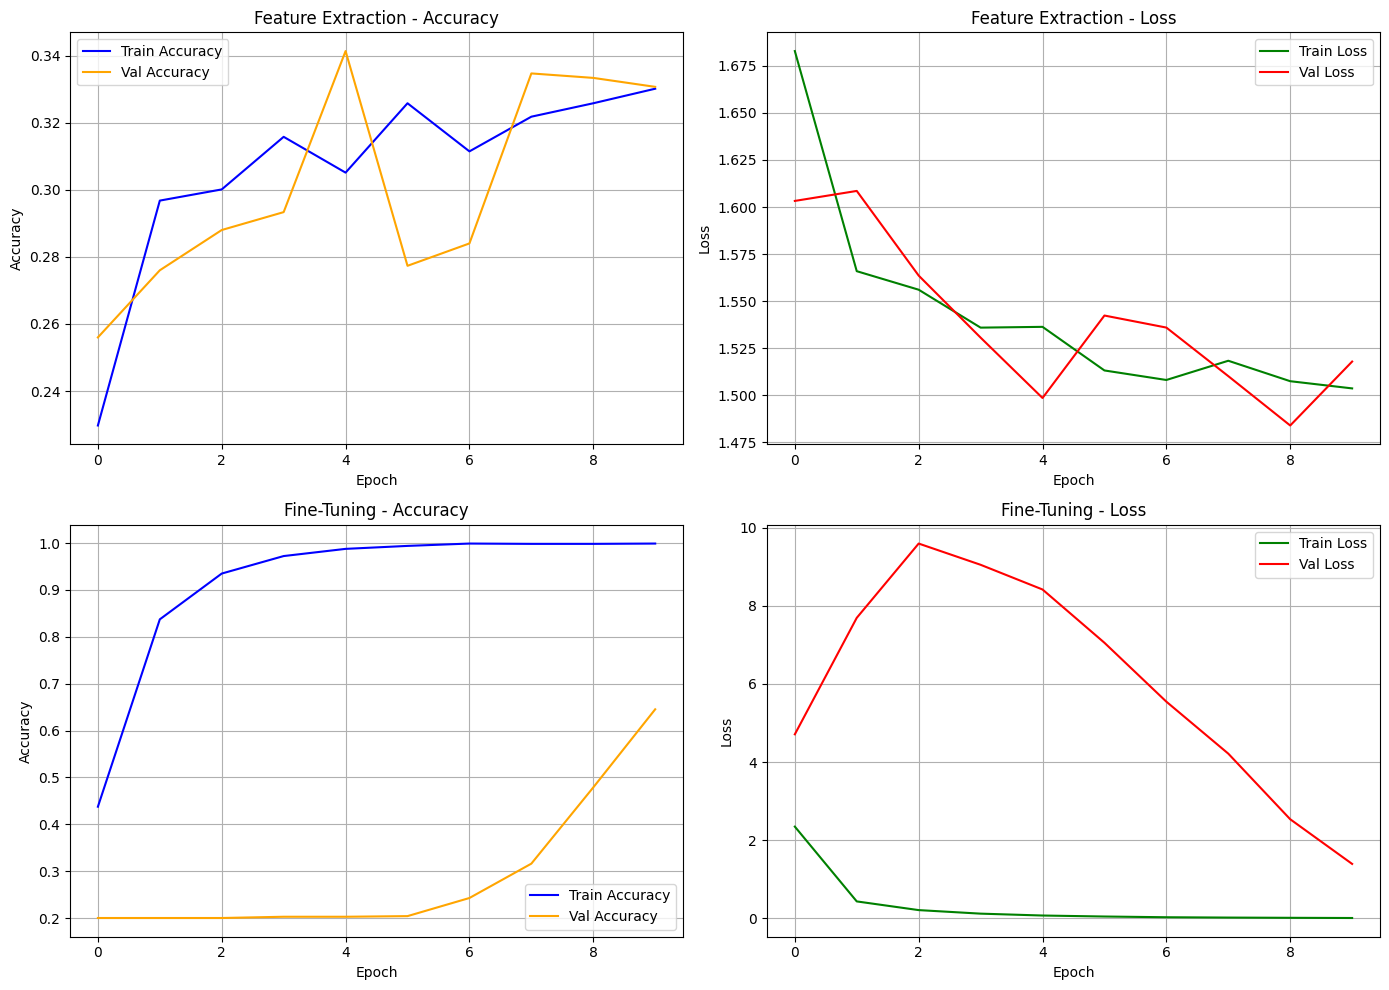

In [ ]:
import matplotlib.pyplot as plt

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# --- 1. Feature Extraction Accuracy ---
axs[0, 0].plot(history_feature_extraction.history['accuracy'], label='Train Accuracy', color='blue')
axs[0, 0].plot(history_feature_extraction.history['val_accuracy'], label='Val Accuracy', color='orange')
axs[0, 0].set_title('Feature Extraction - Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()
axs[0, 0].grid(True)

# --- 2. Feature Extraction Loss ---
axs[0, 1].plot(history_feature_extraction.history['loss'], label='Train Loss', color='green')
axs[0, 1].plot(history_feature_extraction.history['val_loss'], label='Val Loss', color='red')
axs[0, 1].set_title('Feature Extraction - Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- 3. Fine-Tuning Accuracy ---
axs[1, 0].plot(history_fine_tuning.history['accuracy'], label='Train Accuracy', color='blue')
axs[1, 0].plot(history_fine_tuning.history['val_accuracy'], label='Val Accuracy', color='orange')
axs[1, 0].set_title('Fine-Tuning - Accuracy')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# --- 4. Fine-Tuning Loss ---
axs[1, 1].plot(history_fine_tuning.history['loss'], label='Train Loss', color='green')
axs[1, 1].plot(history_fine_tuning.history['val_loss'], label='Val Loss', color='red')
axs[1, 1].set_title('Fine-Tuning - Loss')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()
